In [34]:
source("00_functions.R")
require(ggplot2)


 loading required packages



In [1]:
################################# hvs_rslts ###################################

#' function produces and compares hypervolumes
#' 
#' returns a object of class hv.rslts with summary stats and comparisons of hypervolumes
#' @param df a dataframe which is the axis of hypervolume as columns and plots/census as rows 
#' @param axis - vector of axis from which to draw hypervolumes
#' @export
#' @examples
#' hvs_rslts(df, axis = c("PC1", "PC2", "PC3"))

hvs_rslts <- function(df, axis, what = "seq", census_time){

  df = standardise_time(df, axis, census_time)
  
  df <- scale_axis(df, axis)

	# make list of hv names to work off 
  names <- c()
  for (p in unique(df$plot)){ for (c in unique(df$census)){
    names <- c(names, paste0(p, "_", c)) }}

  cols = c("plot", "census", paste0("centroid_", axis), paste0(axis, "_l"),
           paste0(axis, "_h"))

	# empty list to store hypervolumes as they're built
  hvlist <- list()

	# construct df to store summary stats for each hv
  rslts           <- data.frame(matrix(NA, nrow = length(names), ncol = length(cols)))
  colnames(rslts) <- cols
  rownames(rslts) <- names
  rslts$plot_c    <- names

  cat("\n")
    
  for (i in names){
    
    cat("\rBuilding Hypervolume ", sprintf("%02d", which(names == i)), " of ",
        sprintf("%02d", length(names)), ": ",
        sprintf(paste0("%-0", max(nchar(names)), "s"), i))

    p <- unlist(strsplit(i, "_"))[[1]]  # plot
    c <- unlist(strsplit(i, "_"))[[2]]  # census

		# subset of the pca space with require plot/census and PCs
    tmp <- subset(df, plot == p & census == c,
                  select = colnames(df)[!(colnames(df) %in% c("plot", "subplot", "census"))])

    if (nrow(tmp) < 2){
      hv <- NA
    } else{
      hv <- hypervolume_gaussian(tmp, name = i, verbose = FALSE)
    }
    
    hvlist[[i]] <- hv
      
    rslts[i, "plot"]   <- unlist(strsplit(i, "_"))[1]
    rslts[i, "census"] <- unlist(strsplit(i, "_"))[2]

    if (class(hv) == "Hypervolume"){

      rslts[i, "volume"]       <- hv@Volume

      a <- as.data.frame(get_centroid(hv))

      for (z in rownames(a)){
        rslts[i, paste0("centroid_", z)] <- a[z, ]
        rslts[i, paste0(z, "_l")]        <- min(hv@RandomPoints[,z])
        rslts[i, paste0(z, "_h")]        <- max(hv@RandomPoints[,z])
      }
    }     
  }
  
  # put results through compare census
  compare <- compare_census(rslts, hvlist, what = what)

  # save output to hv.rslts class
  out <- new("hv.rslts", hvlist = hvlist, rslts = rslts, compare = compare)

  cat("\n")

  return(out)
}


In [53]:
mamls_df = read.csv("../Results/m_test_mx.csv", row.names=1)
mamls_cen = read.csv("../Results/m_test_diff.csv")
mamls_agb = read.csv("../Results/m_test_agb.csv")

pca.rslt_mamls = do_pca(mamls_df, scale = F, plot = F)


Building Hypervolume  91  of  91 :  OG2-W_2013 
Comparing Hypervolume 78  of  78 :  OG2-W_2016-2017 


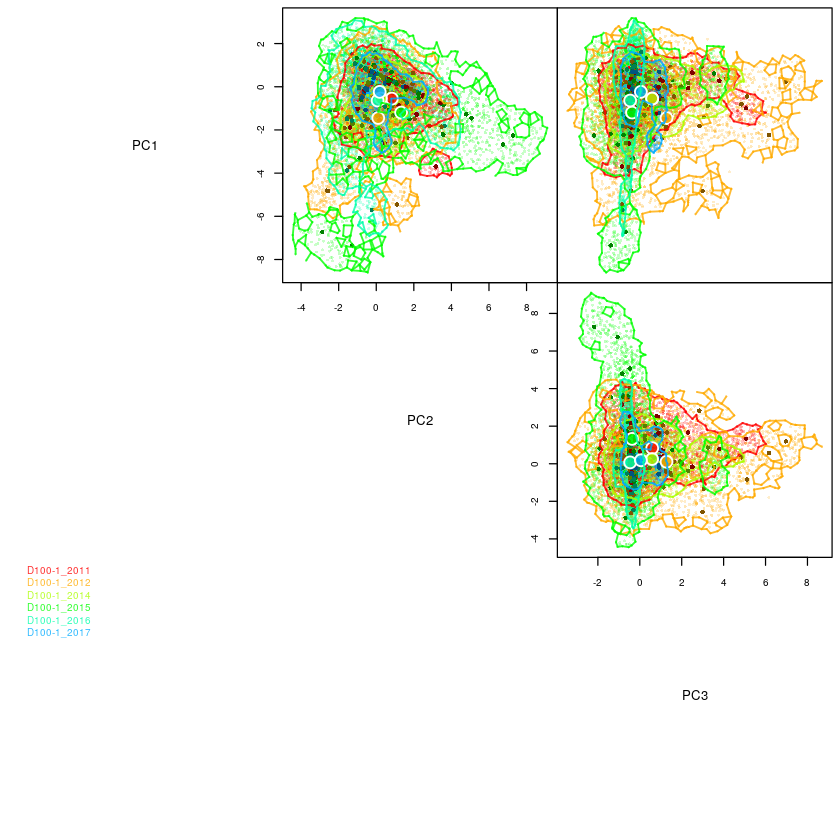

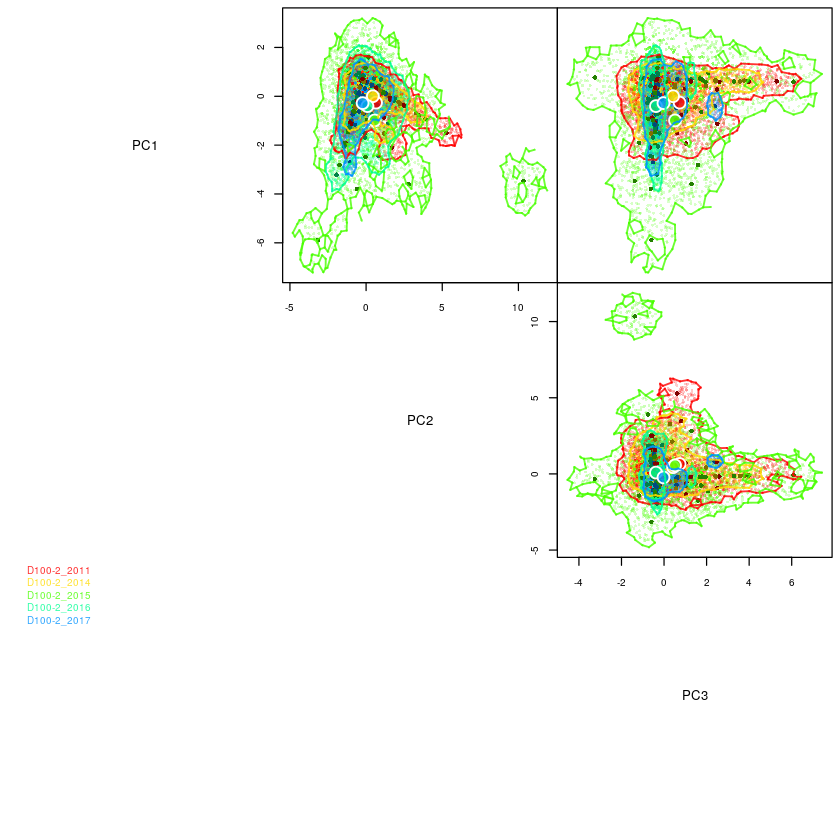

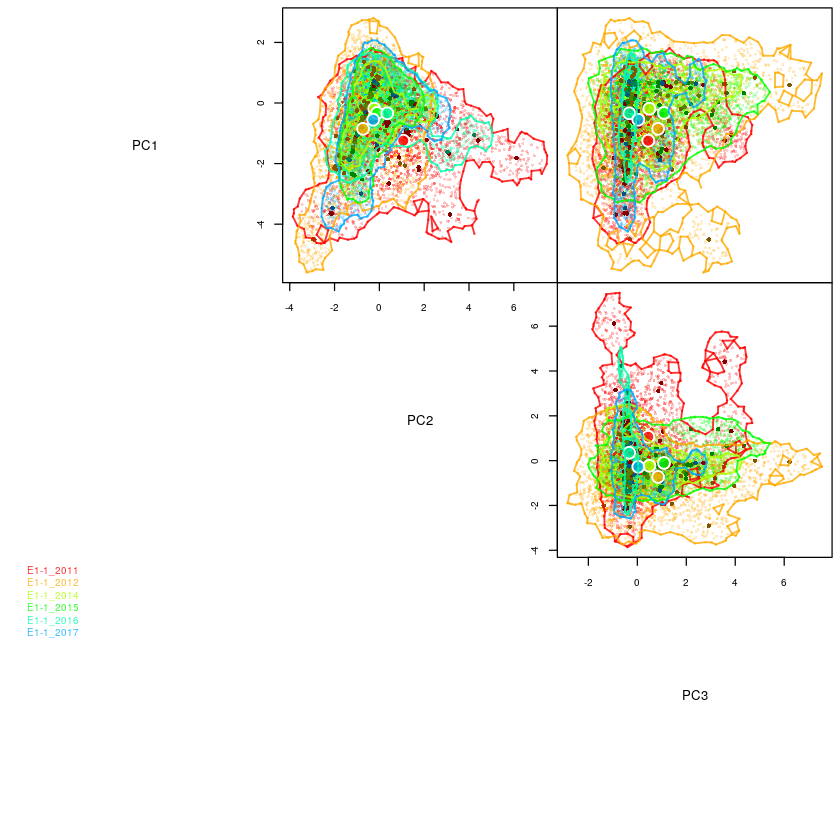

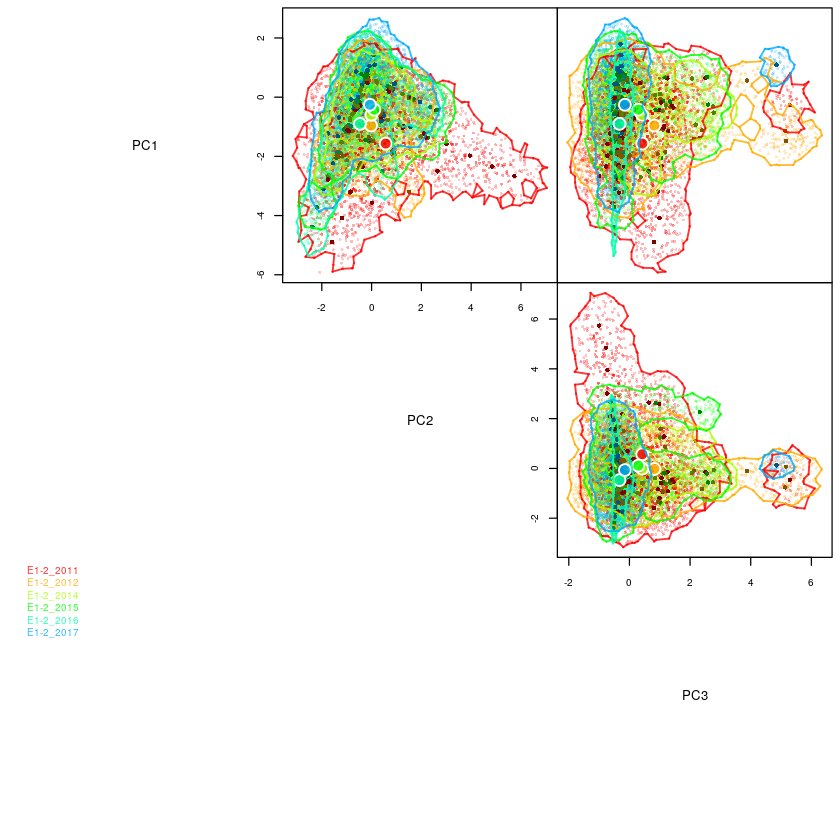

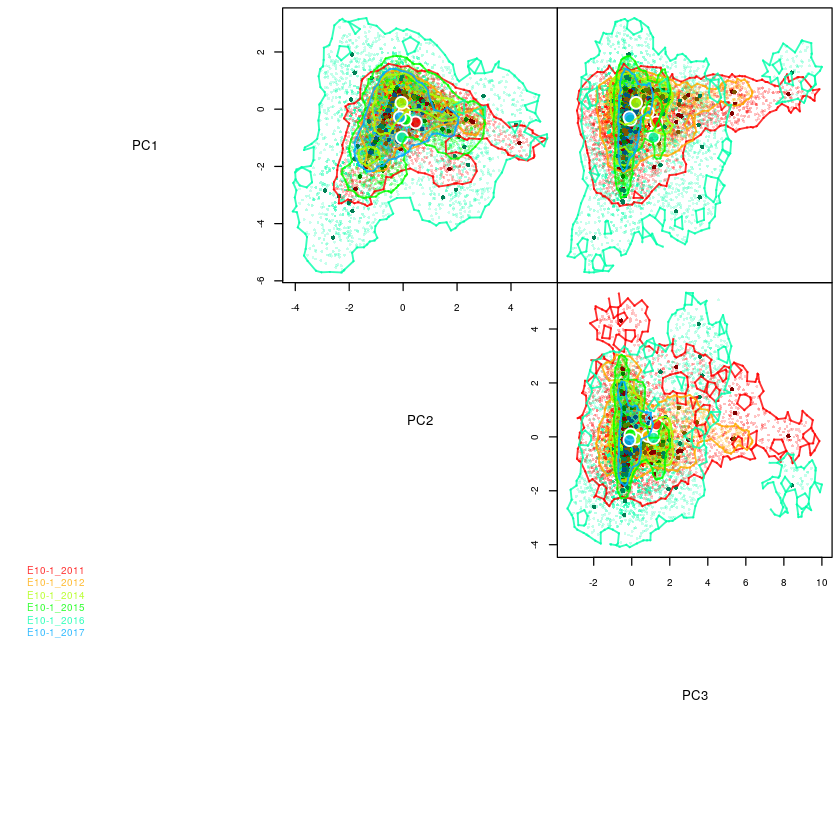

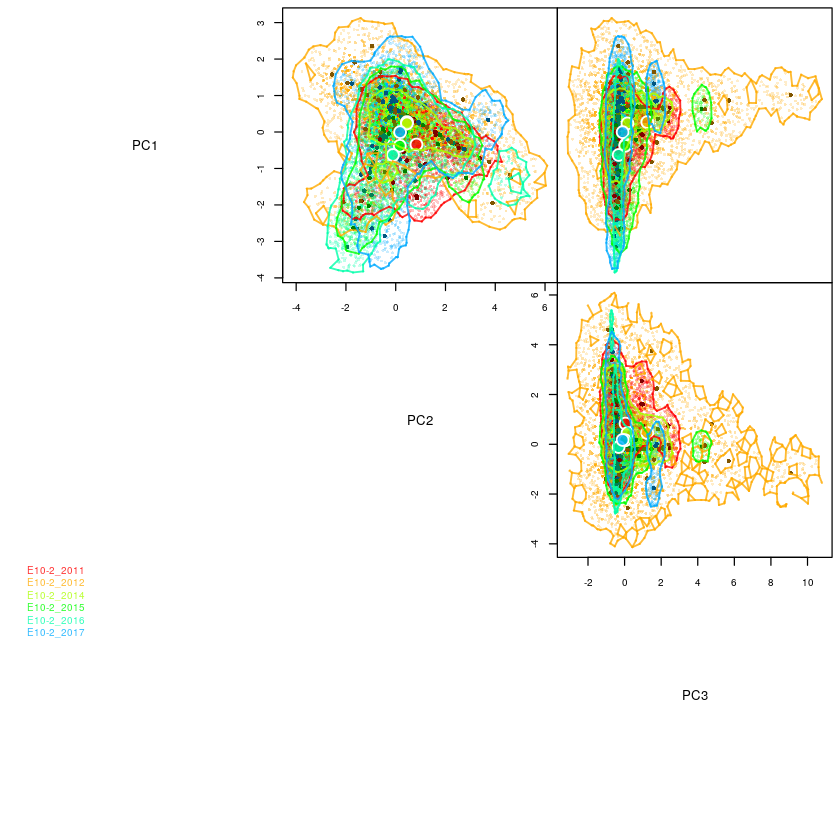

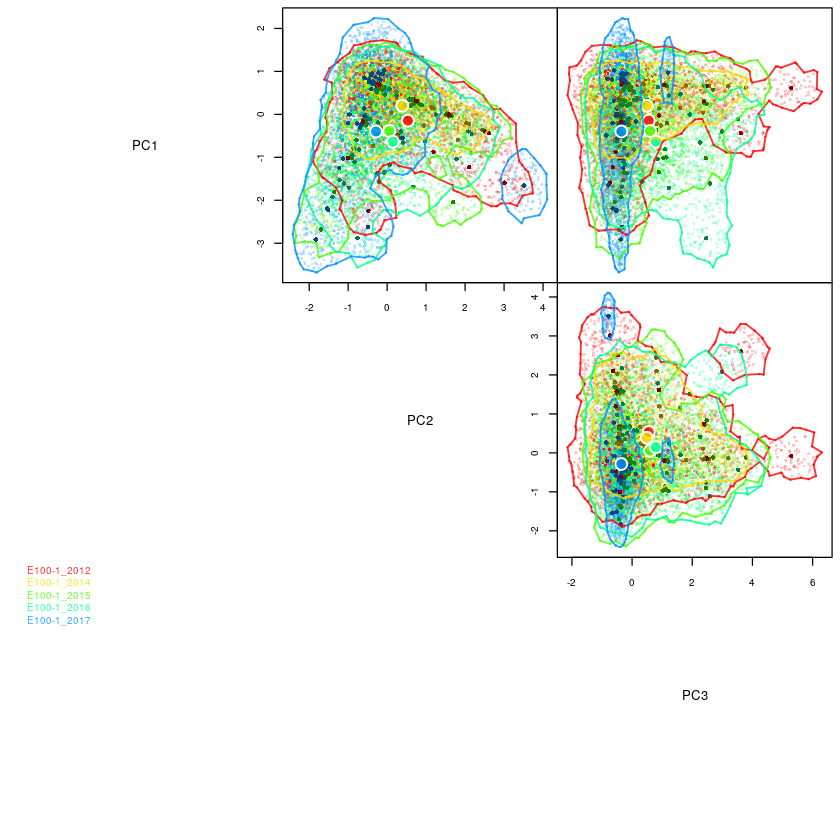

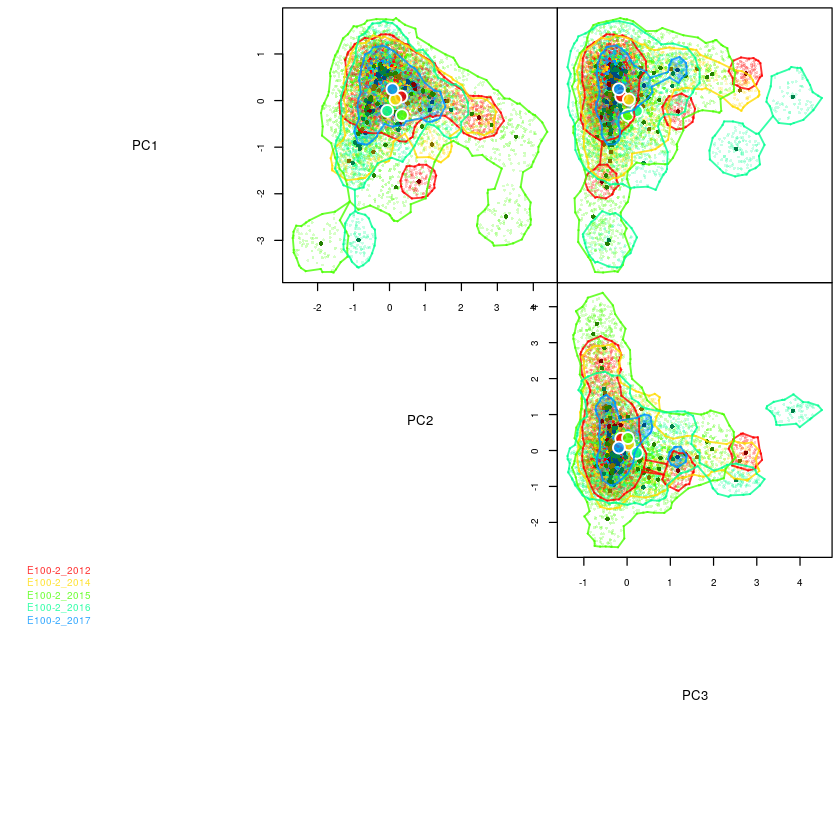

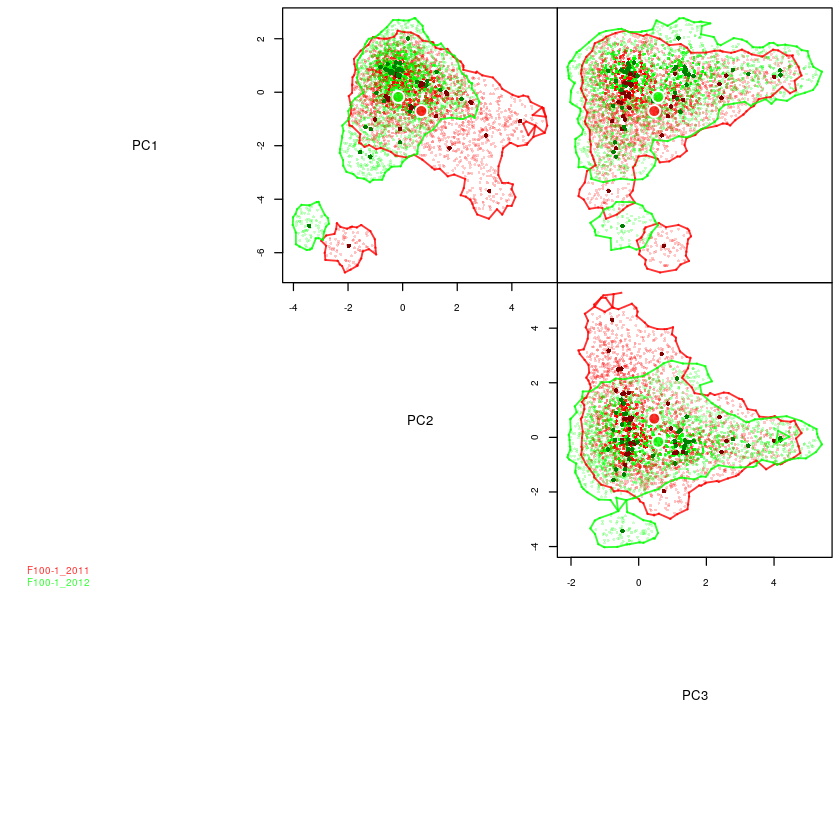

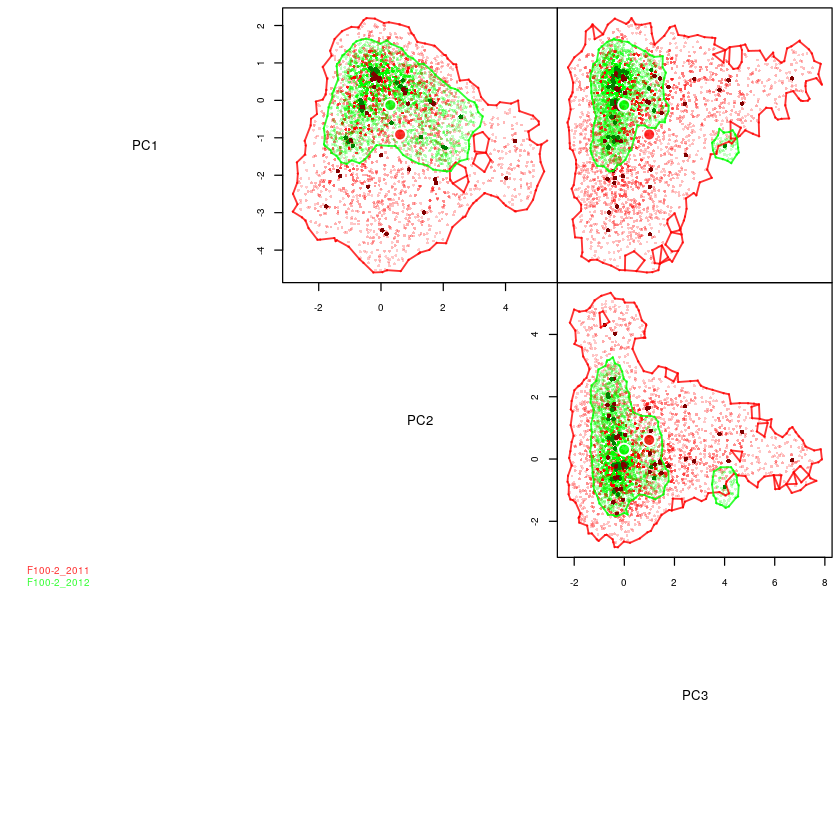

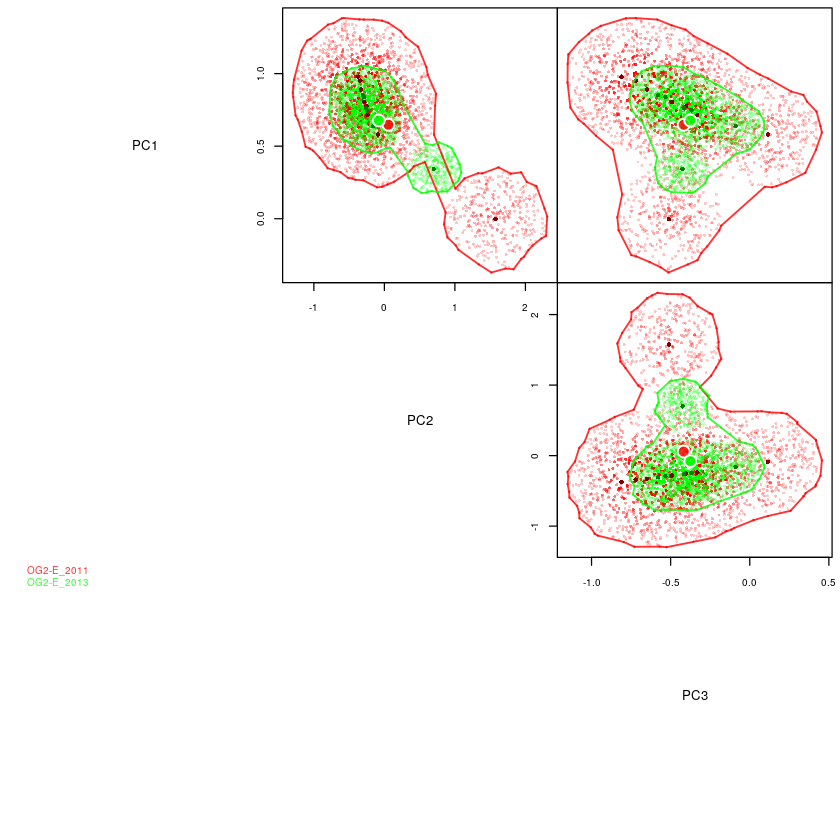

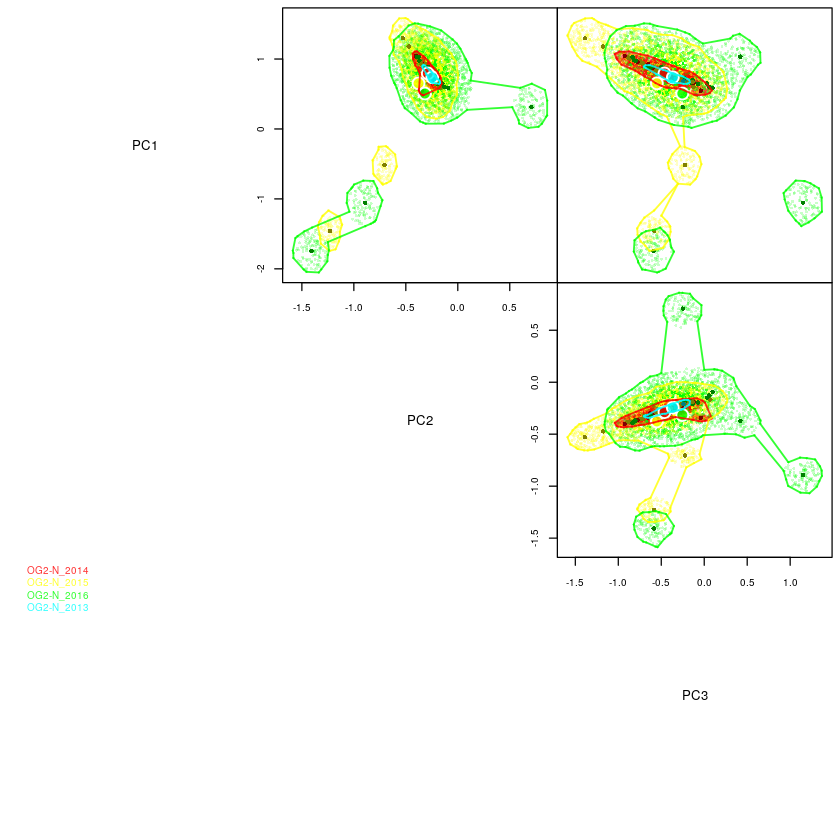

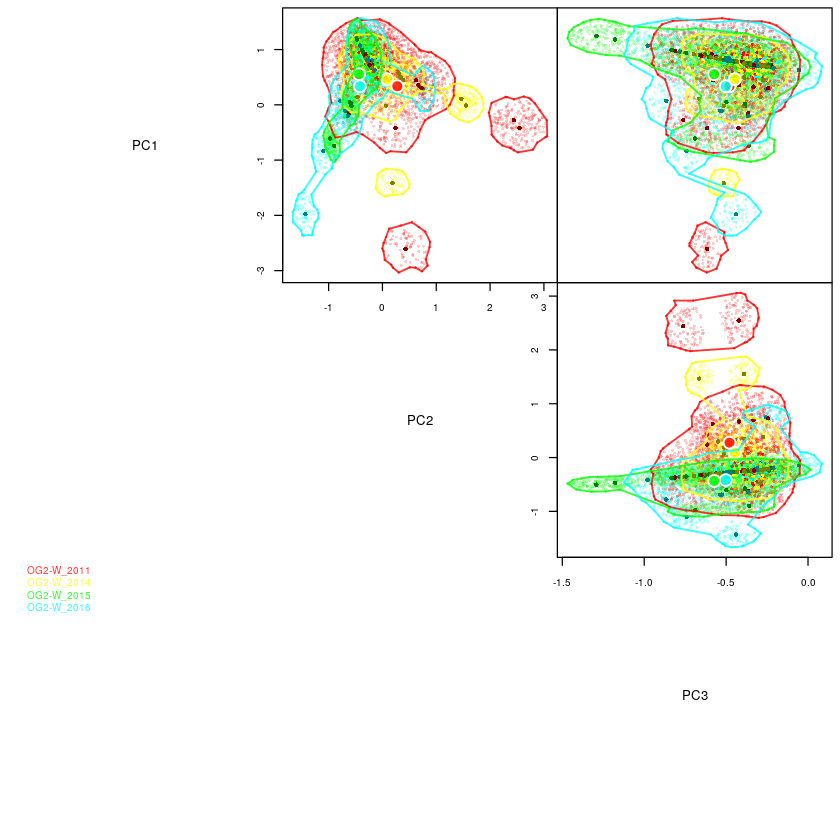

In [40]:
hvs_rslts_mamls = hvs_rslts(pca.rslt_mamls@axis, axis = c("PC1", "PC2", "PC3"), "seq", mamls_cen)
plot_hvs(hvs_rslts_mamls)